In [50]:
from autograd import grad as compute_grad   
import autograd.numpy as np
import numpy as npo
import copy
from autograd import grad as compute_grad   
from datetime import datetime 

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load data: face images

Load in data, transform via original method, transform via new method, compare features to make sure everything looks good.

In [2]:
 def load_data(datapath):
    # load in data
    data = np.loadtxt(datapath,delimiter = ',')

    # import data and reshape appropriately
    X = data[:,:-1]
    y = data[:,-1:]
    
    return X,y

Load in the data, and produce image tensor.

In [3]:
# load data
cvsname = 'feat_face_data.csv'
X, Y = load_data(cvsname)

In [5]:
print('Face data label shape:',np.shape(Y))
print('Face data input shape:',np.shape(X))

Face data label shape: (10000, 1)
Face data input shape: (10000, 784)


## Here we use a subset of the images to train, and also select a subset to Cross Validation

In [6]:
ind = np.random.permutation(len(Y))

### Training dataset: 1500 images

In [10]:
x_train = X[ind[:1500],:]
y_train = Y[ind[:1500]]

Here we need to convert the x_train matrix to N by P.

In [11]:
x_train = x_train.T
print(np.shape(x_train))

(784, 1500)


### Validation dataset: 1000 images

In [12]:
x_val = X[ind[1500:2500],:]
y_val = Y[ind[1500:2500]]

In [13]:
print(np.shape(x_val))
print(np.shape(y_val))

(1000, 784)
(1000, 1)


# 2. Preprocessing on image dataset

### Normalization

In [14]:
# standard normalization function - input data, output standaard normalized version
def standard_normalize(data):
    # compute the mean and standard deviation of the input
    data_means = np.mean(data,axis = 1)[:,np.newaxis]
    data_stds = np.std(data,axis = 1)[:,np.newaxis]   

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(data_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((data_stds.shape))
        adjust[ind] = 1.0
        data_stds += adjust

    # return standard normalized data 
    return (data - data_means)/data_stds

Use it like this

In [15]:
x_normalized = standard_normalize(x_train)
# Need to reshape back to P*N as input to feed to CNN model
x_normalized_train = x_normalized.T
print(np.shape(x_normalized_train))

(1500, 784)


# 3. Model

## Basic CNN model:  one layer CNN + linear combination

In [16]:
class tensor_conv_layer:
    def load_data(self,x,y):
        self.x = x
        self.y = y
    
    # convolution function
    def conv_function(self,tensor_window):
        # reshape P * kernel_size * kernel_size to P * kernel_size**2(element)
        tensor_window = np.reshape(tensor_window,(np.shape(tensor_window)[0],np.shape(tensor_window)[1]*np.shape(tensor_window)[2]))
        t = np.dot(self.kernels,tensor_window.T)# this dot same as conv!!!!! and IT compute all the kernels at once!!!!
        return t# num_kernels(8) * P, that means every image at this location window, the 8 vals for 8 kernels.

    # pooling / downsampling parameters
    def pool_function(self,tensor_window):
        #tensor window is P * pool_window_size * pool_window_size
        #Then t return P images, under this window's maximum vals.
        t = np.max(tensor_window,axis = (1,2))
        return t# P 

    # activation 
    def activation(self,tensor_window):
        return np.maximum(0,tensor_window)

    # pad image with appropriate number of zeros for convolution
    def pad_tensor(self,tensor,kernel_size):
        
        #kernel_size must be odd number, so we want to make sure which kernels(size) we will train.
        odd_nums = np.array([int(2*n + 1) for n in range(100)])
        #find the indice of odd_nums == kernel_size, which is represented by an array, so we need to add [0][0]
        pad_val = np.argwhere(odd_nums == kernel_size)[0][0]
        #padded the whole cuboid, (P,N+2L,N+2L)
        tensor_padded = np.zeros((np.shape(tensor)[0], np.shape(tensor)[1] + 2*pad_val,np.shape(tensor)[2] + 2*pad_val))
        #compute the whole tensor
        tensor_padded[:,pad_val:-pad_val,pad_val:-pad_val] = tensor
        return tensor_padded    
    
    # sliding window for image augmentation
    def sliding_window_tensor(self,tensor,window_size,stride,func):
        # grab image size, set container for results
        image_size = np.shape(tensor)[1]
        results = []
        
        # slide window over input image with given window size / stride and function
        for i in np.arange(0, image_size - window_size + 1, stride):
            for j in np.arange(0, image_size - window_size + 1, stride):
                # take a window of input tensor, here we take the whole images(tensor) cuboid window, 3-D version.#!!!!
                # P * kernel_size * kernel_size(when func is conv_func)
                tensor_window =  tensor[:,i:i+window_size, j:j+window_size]
                
                # now process entire windowed tensor at once
                tensor_window = np.array(tensor_window)
                yo = func(tensor_window)

                # store weight
                results.append(yo)
        
        # re-shape properly
        results = np.array(results)
        results = results.swapaxes(0,1)
        #P*(pooling_window_num)
        if func == self.conv_function:
            results = results.swapaxes(1,2)

        ##results = np.reshape(results,(np.shape(results)[0]*np.shape(results)[1],np.shape(results)[2]*np.shape(results)[3]))   
        # return results in numpy array format
        return results # shape is num_kernels * P * (image_size)**2

    # make feature map
    def make_feature_tensor(self,tensor):
        # create feature map via convolution --> returns flattened convolution calculations
        conv_stride = 1
        feature_tensor = self.sliding_window_tensor(tensor,self.kernel_size,conv_stride,self.conv_function) 

        # re-shape convolution output ---> to square of same size as original input
        num_filters = np.shape(feature_tensor)[0]
        num_images = np.shape(feature_tensor)[1]
        square_dim = int((np.shape(feature_tensor)[2])**(0.5))
        #shape is num_kernels * P * (image_size) * (image_size) , which means from the flatten to the orignal size
        # that means with each kernel, every image new feature.
        feature_tensor = np.reshape(feature_tensor,(num_filters,num_images,square_dim,square_dim))
        
        # shove feature map through nonlinearity
        feature_tensor = self.activation(feature_tensor)

        # pool feature map --- i.e., downsample it
        pool_stride = 3
        pool_window_size = 6
        downsampled_feature_map = []
        # loop every processed tensor, which through 8 kernels.
        for t in range(np.shape(feature_tensor)[0]):
            temp_tens = feature_tensor[t,:,:,:]
            d = self.sliding_window_tensor(temp_tens,pool_window_size,pool_stride,self.pool_function)
            downsampled_feature_map.append(d)
        downsampled_feature_map = np.array(downsampled_feature_map)
        #num_kernels * P * pooling_window_num

        # return downsampled feature map --> flattened
        return downsampled_feature_map

    # our normalization function
    #def normalize(self,data,data_mean,data_std):
        #normalized_data = (data - data_mean)/(data_std + 10**(-5))
        #return normalized_data

    # convolution layer
    def conv_layer(self,tensor,kernels):
        #### prep input tensor #####
        # pluck out dimensions for image-tensor reshape
        num_images = np.shape(tensor)[0]
        num_kernels = np.shape(kernels)[0]
        
        # create tensor out of input images (assumed to be stacked vertically as columns)
        tensor = np.reshape(tensor,(np.shape(tensor)[0],int((np.shape(tensor)[1])**(0.5)),int( (np.shape(tensor)[1])**(0.5))),order = 'F')

        # pad tensor
        kernel = kernels[0]
        self.kernel_size = np.shape(kernel)[0]
        padded_tensor = self.pad_tensor(tensor,self.kernel_size)

        #### prep kernels - reshape into array for more effecient computation ####
        self.kernels = np.reshape(kernels,(np.shape(kernels)[0],np.shape(kernels)[1]*np.shape(kernels)[2]))
        
        #### compute convolution feature maps / downsample via pooling one map at a time over entire tensor #####
        # compute feature map for current image using current convolution kernel
        feature_tensor = self.make_feature_tensor(padded_tensor)

        feature_tensor = feature_tensor.swapaxes(0,1)
        #P * num_kernels * pooling_window_num
        feature_tensor = np.reshape(feature_tensor, (np.shape(feature_tensor)[0],np.shape(feature_tensor)[1]*np.shape(feature_tensor)[2]),order = 'F')
        
        return feature_tensor# P * new features(N)
    
    def predict(self,x,w):
        # pass input data through convolutional layer
        # the kernels are the weights for CNN
        x_conv = self.conv_layer(x,w[0])
        
        # take inner product against output of conv layer
        value = w[1][0] + np.dot(x_conv,w[1][1:])
        return value
    
    # the softmax cost function 
    def softmax(self,w):
        cost  = np.sum(np.log(1 + np.exp((-self.y)*(self.predict(self.x,w)))))
        return cost
    
    # the softmax cost - with minibatch input
    def minibatch_softmax(self,w,iter):
        # get subset of points
        x_p = self.x[iter,:]
        y_p = self.y[iter]
    
        # compute cost over just this subset
        cost  = np.sum(np.log(1 + np.exp((-y_p)*(self.predict(x_p,w)))))
        return cost
    
    def count(self,w):
        return 0.25*np.sum((np.sign(self.predict(self.x,w)) - self.y)**2)

# 4. Training Algorithm 

## 4.1 Gradient descent

In [17]:
from autograd.misc.flatten import flatten
from autograd.misc.flatten import flatten_func

# gradient descent function
def gradient_descent(g,w_unflat,alpha_choice,max_its,version,**kwargs):
    verbose = False
    if 'verbose' in kwargs:
        verbose = kwargs['verbose']

    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w_unflat)
    grad = compute_grad(g)

    # record history
    w_hist = []
    w_hist.append(w_unflat)

    # over the line
    for k in range(max_its):   
        if verbose == True:
            if np.mod(k,5) == 0:
                print ('started step ' + str(k) + ' of ' + str(max_its))
                
                
         # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
            
                
        # plug in value into func and derivative
        grad_eval = grad(w_unflat)
        grad_eval, _ = flatten(grad_eval)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm

        # take descent step 
        w = w - alpha*grad_eval

        # record weight update
        w_unflat = unflatten(w)
        w_hist.append(w_unflat)
        
    if verbose == True:
        print ('finished all ' + str(max_its) + ' steps')

    return w_hist

## 4.2 Minibatch gradient descent

In [18]:
def minibatch_gradient_descent(g,w,alpha,batch_size,max_its,version,**kwargs): 
    verbose = False
    if 'verbose' in kwargs:
        verbose = kwargs['verbose']
        
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))
    
    # how many mini-batches equal the entire dataset
    num_batches = int(np.ceil(np.divide(num_pts,batch_size)))
    # over the line
    for k in range(max_its):
        if verbose == True:
            if np.mod(k,5) == 0:
                print ('started epoch ' + str(k) + ' of ' + str(max_its))
        # loop over each minibatch
        for b in range(num_batches):
            # collect indices of current mini-batch
            # the batch_inds is a list
            batch_inds = np.arange(b*batch_size,min((b+1)*batch_size,num_pts))

            # plug in value into func and derivative
            grad_eval = grad(w,batch_inds)
            grad_eval.shape = np.shape(w)

            ### normalized or unnormalized descent step? ###
            if version == 'normalized':
                grad_norm = np.linalg.norm(grad_eval)
                if grad_norm == 0:
                    grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
                grad_eval /= grad_norm
            
            # take descent step with momentum
            w = w - alpha*grad_eval

        # record weight update
        w_hist.append(unflatten(w))
    
    if verbose == True:
        print ('finished all ' + str(max_its) + ' epoch')

    return w_hist

# 5.Experiment

### initialize the weights

In [19]:
# random initialization for kernels
scale = 0.1
kernels = scale*np.random.randn(8,3,3) 

# initialize instance of convnet
tensor_test = tensor_conv_layer()

# run a small set of images through the network to collect final weights size
final_features = tensor_test.conv_layer(x_normalized_train,kernels)
print(np.shape(final_features))
# The pooling_window_num is 64
final_size = np.shape(final_features)[1] + 1

# set final weights, CNN's kernel and linear combination weights
final_weights = scale*np.random.randn(final_size,1)
weights = [kernels,final_weights]

(1500, 512)


### Creat model and cost function with normalization preprocessing.

In [20]:
simple_CNN = tensor_conv_layer()
simple_CNN.load_data(x_normalized_train,y_train)

### Training

#### standrad gradient descent test

In [21]:
startTime= datetime.now() 

# run standard gradient descent
g = simple_CNN.softmax
w = weights
alpha_choice = 10**(-1)
max_its = 100
version = 'normalized'
weight_history_1 =  gradient_descent(g,w,alpha_choice,max_its,version,verbose = True)
timeElapsed=datetime.now()-startTime 

print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

started step 0 of 100
started step 5 of 100
started step 10 of 100
started step 15 of 100
started step 20 of 100
started step 25 of 100
started step 30 of 100
started step 35 of 100
started step 40 of 100
started step 45 of 100
started step 50 of 100
started step 55 of 100
started step 60 of 100
started step 65 of 100
started step 70 of 100
started step 75 of 100
started step 80 of 100
started step 85 of 100
started step 90 of 100
started step 95 of 100
finished all 100 steps
Time elpased (hh:mm:ss.ms) 0:07:05.828419


In [22]:
cost_history_1 = [simple_CNN.softmax(w) for w in weight_history_1]
miss_history_1 = [simple_CNN.count(w) for w in weight_history_1]

####  Mini_batch gradient descent test 

In [23]:
num_pts = len(y_train)

In [24]:
startTime= datetime.now() 

# run minibatch gradient descent
g = simple_CNN.minibatch_softmax
w = weights
alpha_choice = 10**(-1)
max_its = 100
version = 'normalized'
batch_size = 50
weight_history_2 =  minibatch_gradient_descent(g,w,alpha_choice,batch_size,max_its,version,verbose = True)
timeElapsed=datetime.now()-startTime 

print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

started epoch 0 of 100
started epoch 5 of 100
started epoch 10 of 100
started epoch 15 of 100
started epoch 20 of 100
started epoch 25 of 100
started epoch 30 of 100
started epoch 35 of 100
started epoch 40 of 100
started epoch 45 of 100
started epoch 50 of 100
started epoch 55 of 100
started epoch 60 of 100
started epoch 65 of 100
started epoch 70 of 100
started epoch 75 of 100
started epoch 80 of 100
started epoch 85 of 100
started epoch 90 of 100
started epoch 95 of 100
finished all 100 epoch
Time elpased (hh:mm:ss.ms) 0:13:01.073092


In [26]:
cost_history_2 = [simple_CNN.softmax(w) for w in weight_history_2]
miss_history_2 = [simple_CNN.count(w) for w in weight_history_2]

### Plot the cost history comparsion using two version grad descent algorithm

In [28]:
#classify
import classification_comparison_plotter
plotter = classification_comparison_plotter.Visualizer()

<IPython.core.display.Javascript object>


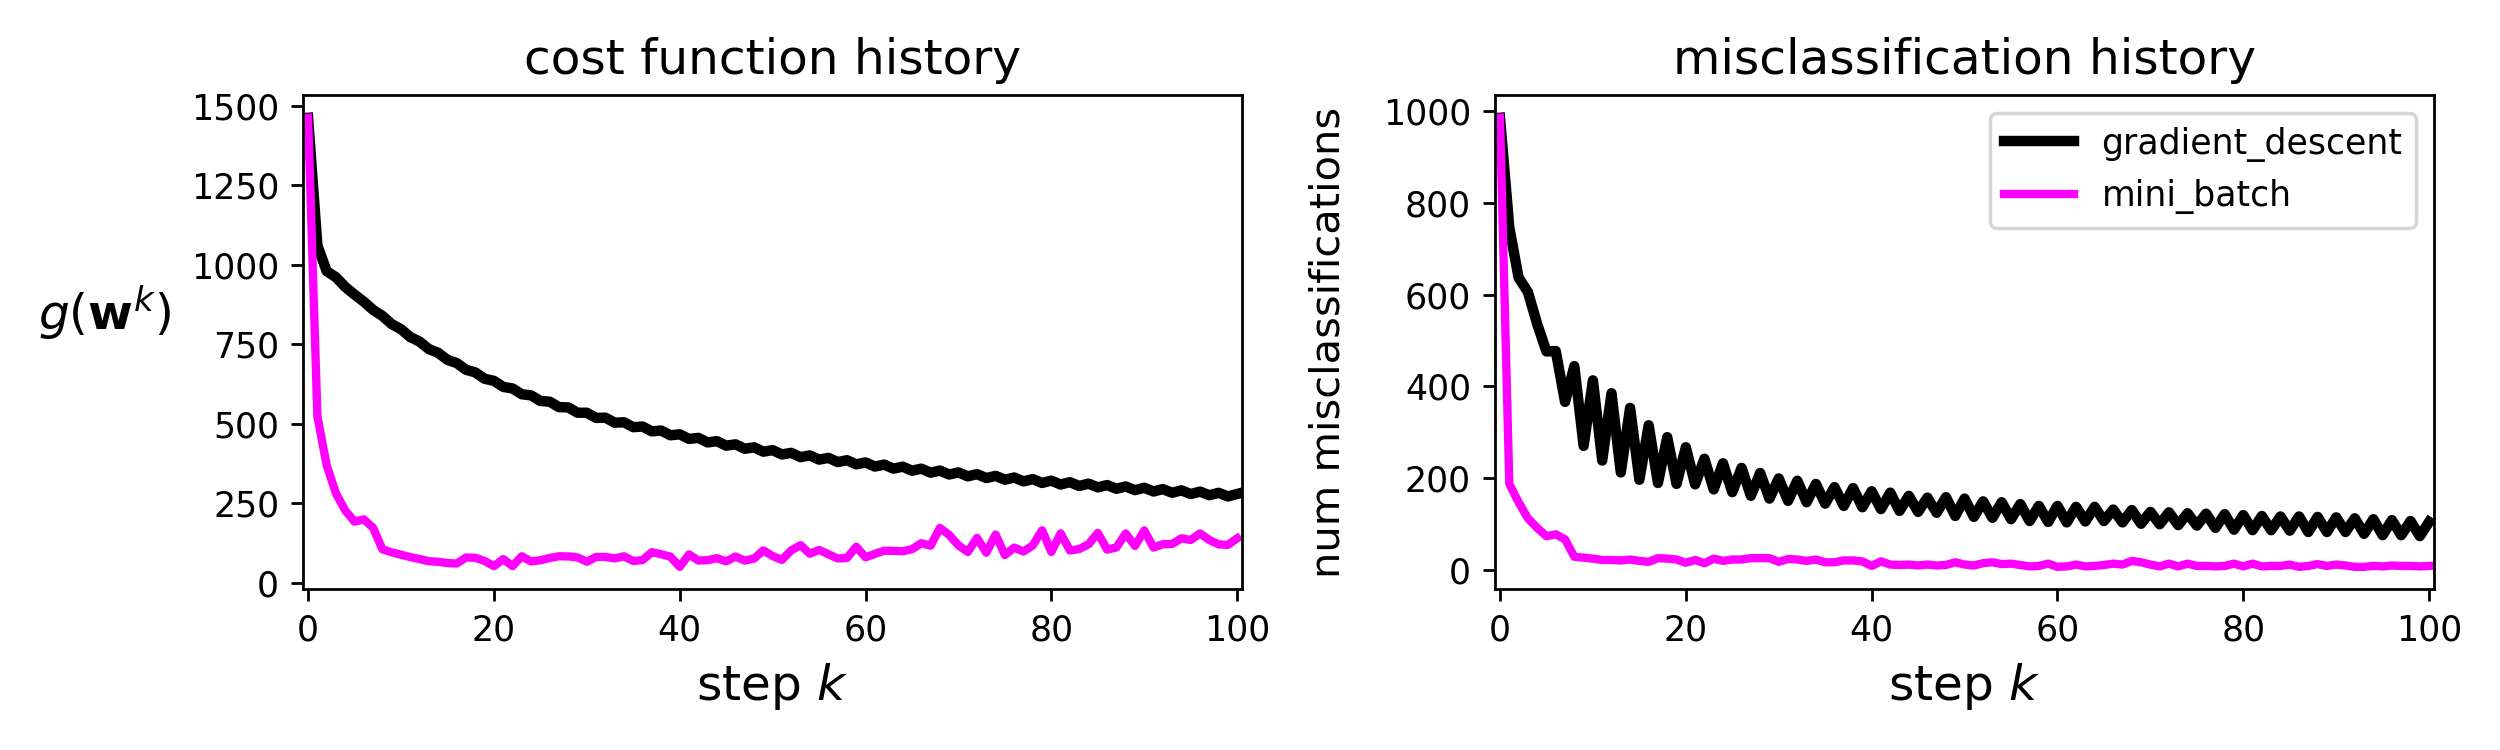

In [51]:
plotter.plot_cost_histories([weight_history_1,weight_history_2],[cost_history_1,cost_history_2],[miss_history_1,miss_history_2],start = 0,labels = ['gradient_descent','mini_batch'] )

### Get the best weights

In [30]:
index_best = np.argmin(miss_history_2)
w_best = weight_history_2[index_best]

In [31]:
print('Training on facial data, the miss classifiction number is ' + str(simple_CNN.count(w_best)))

Training on facial data, the miss classifiction number is 6.0


# 6. Cross-Validation

### Preprocess the validation(test) dataset with Normalization .

In [34]:
x_val_normalized = standard_normalize(x_val.T)
x_val_normalized = x_val_normalized.T
print(np.shape(x_val_normalized))

(1000, 784)


###  plot accuracy

In [35]:
# import plotting library and other necessities
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy

# our plotting function
def plot_accuracy(x,y,weight_histories,predict):
   
    fig, ax = plt.subplots(1, 1, figsize=(10,4))

    accuracy_history=[]
    
    for weight_history in weight_histories:
        
        y_predict = predict(x,weight_history)
        correct_predict = 0
        for i in range(len(y)):
            if np.sign(y_predict[i]) == y[i]:
                correct_predict += 1
        
        accuracy = correct_predict/len(y)
        accuracy_history.append(accuracy)
    
    # plot function and gradient values
    ax.plot(accuracy_history,color = 'r',linewidth = 2)
 
    # label each panel
    ax.set_xlabel('iteration')
    ax.set_ylabel('validation accuracy')
    ax.set_title('accuracy history')
    
    plt.show()

### The accuracy history on facial test dataset

<IPython.core.display.Javascript object>


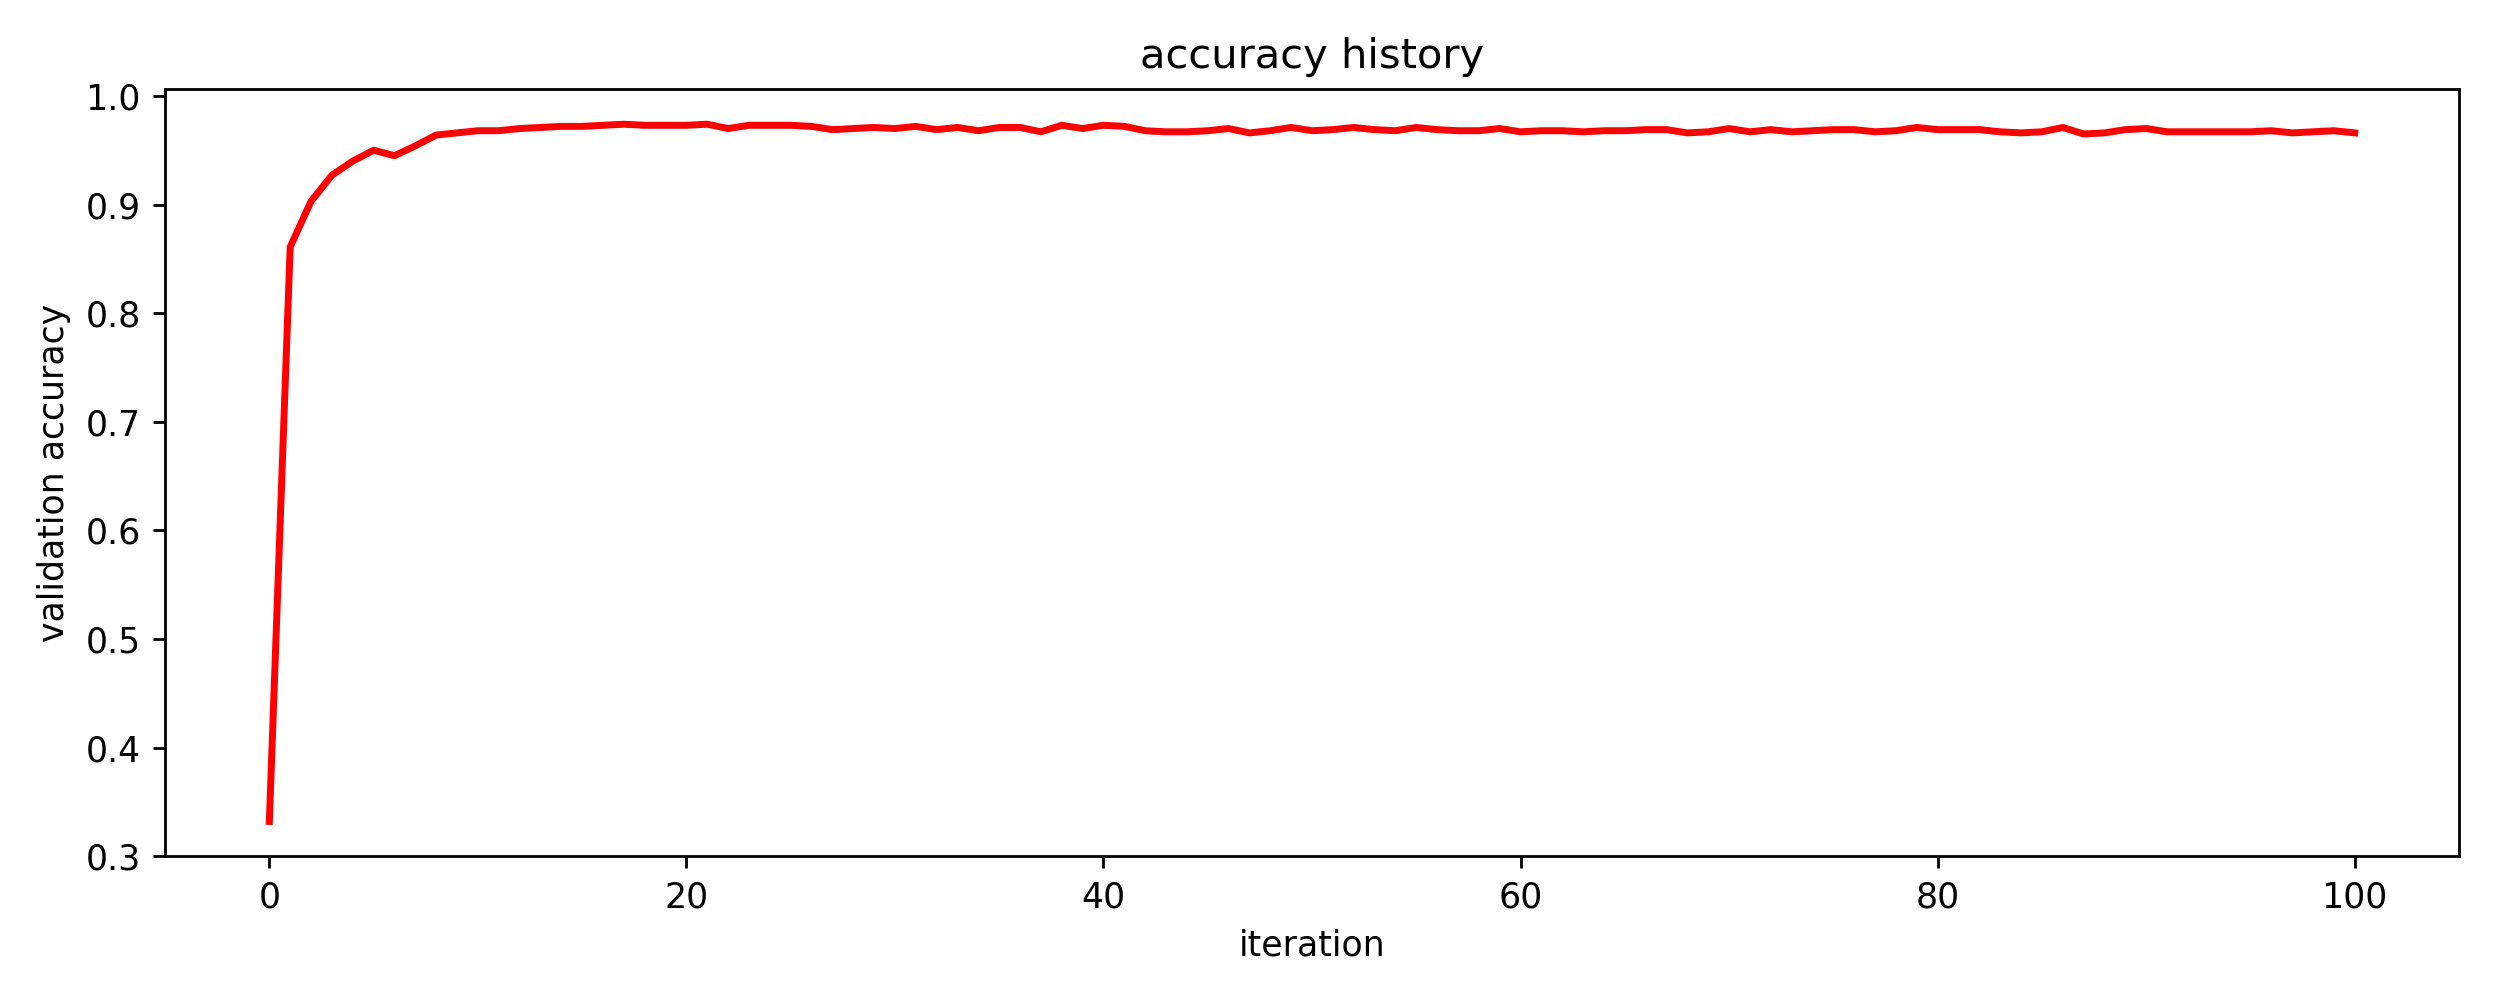

In [52]:
plot_accuracy(x_val_normalized,y_val,weight_history_2,simple_CNN.predict)

In [38]:
print('In the validation dataset, there are 1000 images. According to the graph, when using well tuned model to make predict, and the validation accuracy reaches 97%')

In the validation dataset, there are 1000 images. According to the graph, when using well tuned model to make predict, and the validation accuracy reaches 97%


# 7. Example predictions on Test set

<IPython.core.display.Javascript object>


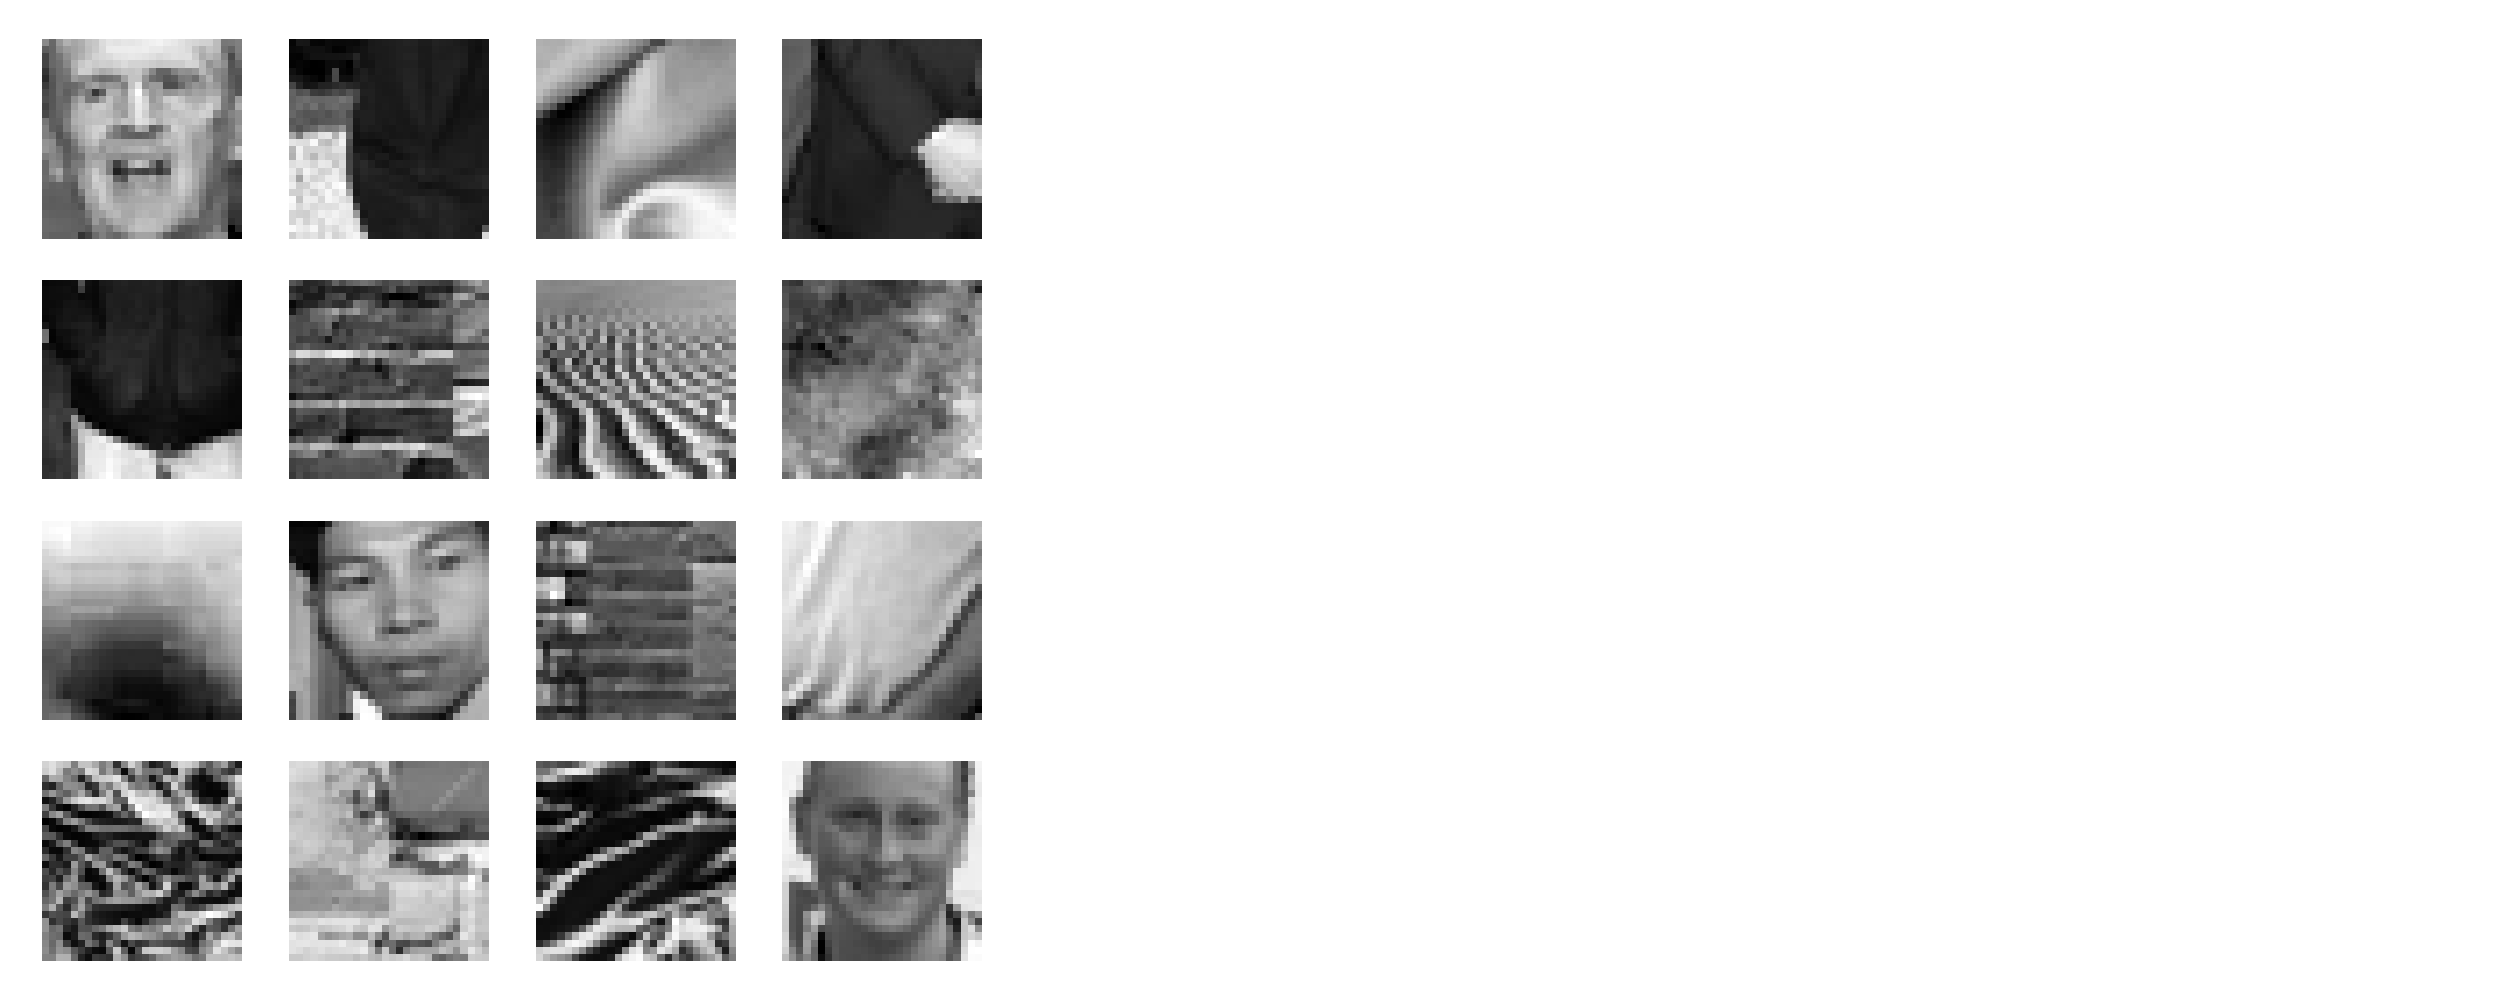

In [57]:
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10,4))
gs=GridSpec(4,10)

for i in range(0, 16):
    fig.add_subplot(gs[i%4 + int(i/4)*10])
    plt.imshow(np.reshape(x_val[i,:],(28,28),1),cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.axis('off') 
    
plt.show()

In [58]:
predict_labels = simple_CNN.predict(x_val_normalized[:16,:],w_best)

In [65]:
predict_list = []
for i in range(len(predict_labels)):
    if np.sign(predict_labels[i]) == 1:
        a = 'Human Face'
        predict_list.append(a)
        
    else:
        a = 'Not Human Face'
        predict_list.append(a)

## Predict the 16 test images above

In [66]:
print(predict_list)

['Human Face', 'Not Human Face', 'Not Human Face', 'Not Human Face', 'Not Human Face', 'Not Human Face', 'Not Human Face', 'Not Human Face', 'Not Human Face', 'Human Face', 'Not Human Face', 'Not Human Face', 'Not Human Face', 'Not Human Face', 'Not Human Face', 'Human Face']
